In [12]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

In [13]:
import torch
from torchvision import transforms
from datasets import load_dataset
from datasets import Dataset as HFDataset
from torch.utils.data import DataLoader

from resources.utils import CovidDataset, plot_class_distribution
from resources.model import (
    create_xception_model, 
    create_resnet50_model, # IMPLEMENTAR A CRITERIO
    create_efficientnet_v2_s_model, # IMPLEMENTAR A CRITERIO
    train_model
)
from resources.visualization import (
    plot_confusion_matrix, 
    visualize_predictions, 
    plot_training_history
)

In [14]:
# Define transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.15),
    transforms.RandomAffine(degrees=0, translate=(0.15, 0.15)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [15]:
# Load dataset
streaming_dataset = load_dataset("Flooki10/autotrain-data-pr_final_covid-19", streaming=True)
train_dataset_raw = HFDataset.from_list(list(streaming_dataset['train']))
val_dataset_raw = HFDataset.from_list(list(streaming_dataset['test']))

# Create dataset instances
train_dataset = CovidDataset(train_dataset_raw, transform=train_transform)
val_dataset = CovidDataset(val_dataset_raw, transform=val_transform)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

README.md:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

C:\Users\jahn\AppData\Roaming\Python\Python312\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\jahn\.cache\huggingface\hub\datasets--Flooki10--autotrain-data-pr_final_covid-19. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Resolving data files:   0%|          | 0/401 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/101 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/198 [00:00<?, ?it/s]

'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: fc1bd249-1688-480b-8bc9-dc39fd80cdc0)')' thrown while requesting GET https://huggingface.co/datasets/Flooki10/autotrain-data-pr_final_covid-19/resolve/a451eadbb53f0ead419ba8dc00f05e5ec60b7273/raw/image_folders/train/Clases/Covid/COVID-108.png
Retrying in 1s [Retry 1/5].


In [16]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create and move model to device
model = create_resnet50_model(num_classes=3)
model = model.to(device)

Using device: cpu


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

C:\Users\jahn\AppData\Roaming\Python\Python312\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\jahn\.cache\huggingface\hub\models--timm--resnet50.a1_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


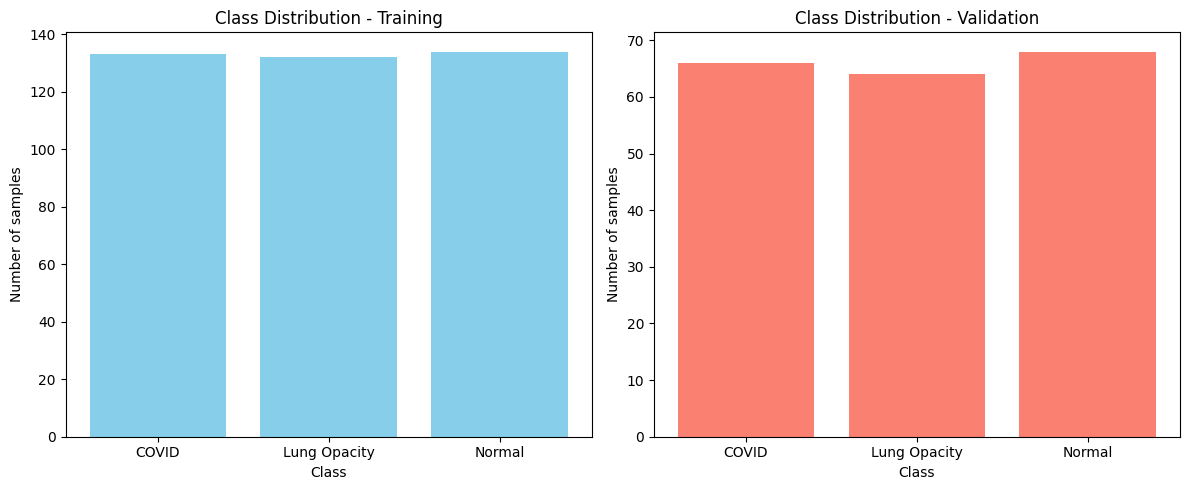

In [17]:
# Define classes
classes = ['COVID', 'Lung Opacity', 'Normal']

# Plot class distribution
plot_class_distribution(train_dataset_raw, val_dataset_raw, classes)

In [18]:
# Training setup
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.3, patience=2, verbose=True
)

C:\Users\jahn\AppData\Roaming\Python\Python312\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [19]:
NUM_EPOCHS = 10
PATH_TO_SAVE_MODELS = "../models/resnet50_models" #Cambiar el nombre a tu criterio
PREFIX_NAME_MODELS = "resnet50_best_model" # nombre prefijo de mis modelos


# Train the model
trained_model, history = train_model(
    model= model,
    train_loader= train_loader,
    val_loader= val_loader,
    criterion= criterion,
    optimizer= optimizer,
    scheduler= scheduler,
    device= device,
    num_epochs= NUM_EPOCHS,
    save_dir= PATH_TO_SAVE_MODELS,
    model_prefix= PREFIX_NAME_MODELS
)

Epoch | Train Loss | Train Acc | Val Loss | Val Acc
------------------------------------------------------
    1 |     1.1064 |    0.3158 |   1.0949 |  0.4040
Model saved: ../models/resnet50_models\resnet50_best_model_epoch_1_4to_intent.pth
    2 |     1.0598 |    0.4662 |   1.0829 |  0.4343
Model saved: ../models/resnet50_models\resnet50_best_model_epoch_2_4to_intent.pth
    3 |     1.0109 |    0.5464 |   1.0686 |  0.5152
Model saved: ../models/resnet50_models\resnet50_best_model_epoch_3_4to_intent.pth
    4 |     0.9207 |    0.6115 |   1.0688 |  0.5556
Model saved: ../models/resnet50_models\resnet50_best_model_epoch_4_4to_intent.pth
    5 |     0.8385 |    0.6617 |   1.0798 |  0.5960
Model saved: ../models/resnet50_models\resnet50_best_model_epoch_5_4to_intent.pth
    6 |     0.7634 |    0.7018 |   1.0310 |  0.5657
    7 |     0.7003 |    0.7268 |   0.9658 |  0.5354
    8 |     0.6316 |    0.7569 |   0.9605 |  0.4949
    9 |     0.5094 |    0.8095 |   0.8780 |  0.5859
   10 |     0.4

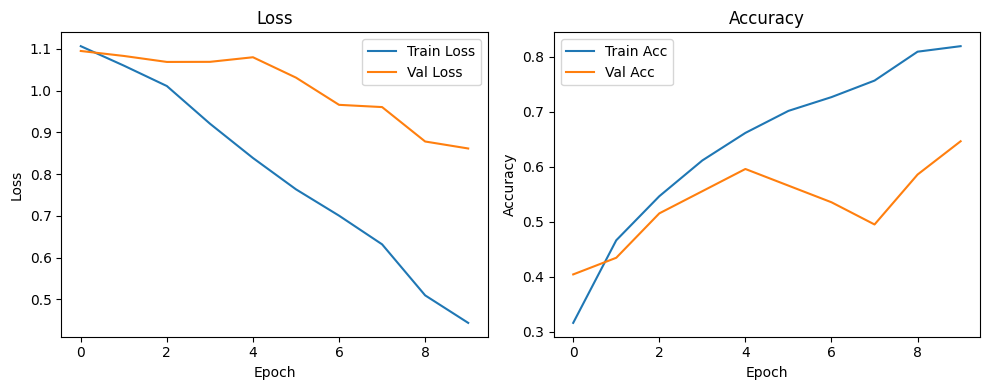

In [20]:
# Plot training history
plot_training_history(
    train_losses=history['train_loss'],
    val_losses=history['val_loss'],
    train_accs=history['train_acc'],
    val_accs=history['val_acc']
)

Classification Report:
              precision    recall  f1-score   support

       COVID       0.94      0.48      0.64        66
Lung Opacity       0.53      0.97      0.68        64
      Normal       0.74      0.50      0.60        68

    accuracy                           0.65       198
   macro avg       0.74      0.65      0.64       198
weighted avg       0.74      0.65      0.64       198



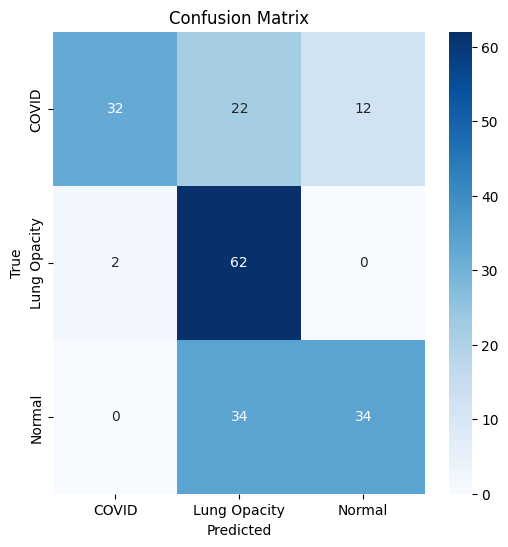

In [21]:
# Evaluate the model
plot_confusion_matrix(trained_model, val_loader, device, classes)

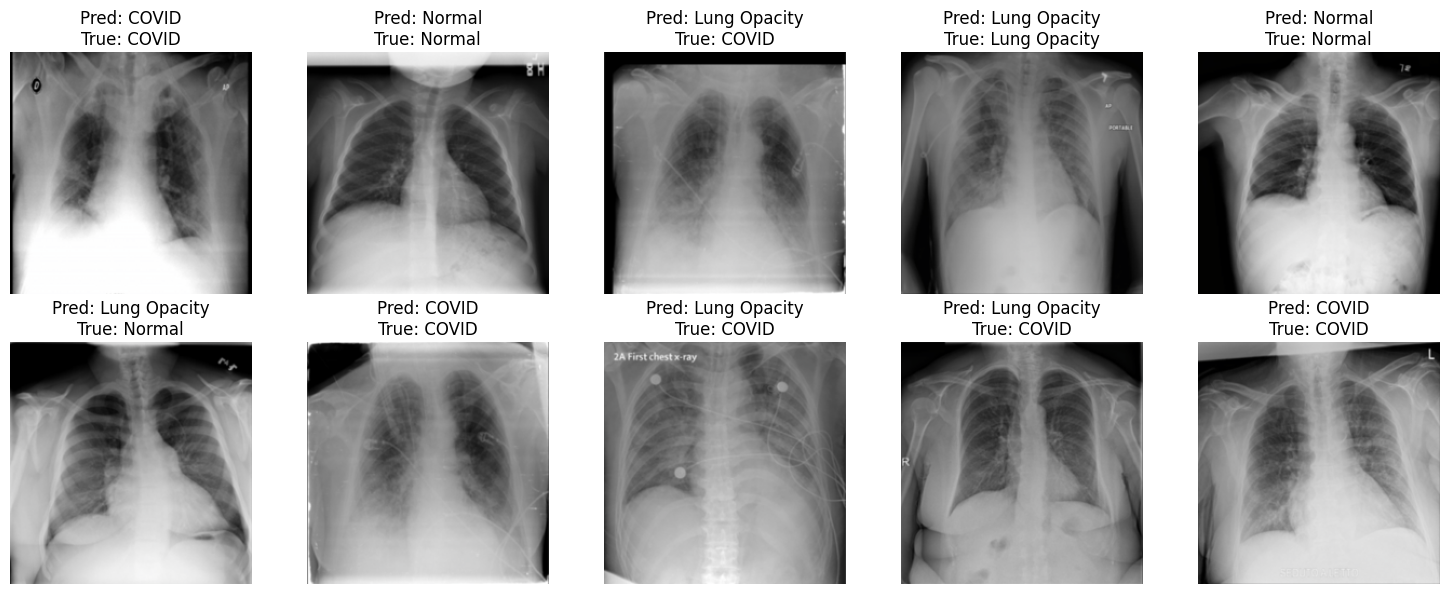

In [22]:
visualize_predictions(trained_model, val_dataset, device, classes)